In [20]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import numpy as np
import random
import time
import statistics
from itertools import chain 

In [2]:
# Для получения токена открыть ссылку в браузере:
# Для контроля над своим токеном, нужно изменить client_id на id своего приложение ВК
# https://oauth.vk.com/authorize?client_id=8009498&display=page&scope=friends&response_type=token&v=5.92&state=123456 

group_api_url = 'https://api.vk.com/method/groups.getMembers?group_id='
id_api_url = 'https://api.vk.com/method/friends.get?user_id='
fields = '&fields=sex,bdate,city,country'
count = '&count=1000'
offset = '&offset='
v = '&v=5.92'
access_token = '&access_token=НУЖНО ВСТАВИТЬ СЮДА ТОКЕН'

In [47]:
# Id группы ВК

# Шоколадный торт 63588708
# Действовать будем МЫ 197777270

vk_group_id = 197777270

In [76]:
def extract_members(group_id):

    list_of_members = []
    
    for offset_number in range(0, 5000, 1000):
        
        url = group_api_url + str(group_id) + offset + str(offset_number) + count + fields + access_token + v
        json_response = requests.get(url).json()
        users = json_response['response']['items']
        list_of_members += users
        
    return list_of_members

In [77]:
# Получаем подробную инфу о пользователях
group_members = extract_members(vk_group_id)

In [78]:
print(len(group_members))

5000


In [79]:
# Example of member's profile

group_members[4000]

{'first_name': 'Евгений',
 'id': 157044601,
 'last_name': 'Еремин',
 'can_access_closed': False,
 'is_closed': True,
 'sex': 2,
 'bdate': '3.4.1988',
 'city': {'id': 2, 'title': 'Санкт-Петербург'},
 'country': {'id': 1, 'title': 'Россия'}}

In [80]:
output = open('group_members_' + str(vk_group_id) + '.pkl', 'wb')
pickle.dump(group_members, output)
output.close()

In [48]:
with open('group_members_' + str(vk_group_id) + '.pkl', 'rb') as f:
    group_members = pickle.load(f)

In [49]:
# List of community members id's

members_ids = []

for member in group_members:
    members_ids.append(member['id'])

In [83]:
# Function takes in user id and returns list of id's of people which are his friends and community members at the 
# same time

def user_friends_list(user_id):
    
    url = id_api_url + str(user_id) + access_token + v
    
    time.sleep(0.12)
    
    try:
        json_response = requests.get(url).json()
    except requests.exceptions.RequestException:
        print('error')
        return []
    
    if 'error' in json_response.keys():
        print('error')
        return []
    
    friends_inside_community_list = list(set(json_response['response']['items']).intersection(members_ids))
    print('success')
    return friends_inside_community_list

In [85]:
url = id_api_url + str(154101110) + access_token + v
print(requests.get(url).json())

{'error': {'error_code': 29, 'error_msg': 'Rate limit reached', 'request_params': [{'key': 'user_id', 'value': '154101110'}, {'key': 'v', 'value': '5.92'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}}


In [84]:
# Создаем файл, в нем список ребер: пары вершина - вершина 

f1 = open('friends_inside_' + str(vk_group_id) + '.txt', 'w')

for member_id in members_ids:
    
    a = user_friends_list(member_id)
    
    if len(a) != 0:
        
        for friend_id in a:
            f1.write('%d' % member_id)
            f1.write(' ')
            f1.write('%d' % friend_id)
            f1.write('\n')

f1.close()

error
error
error
error
error
error
error
error
error
error
error
error


KeyboardInterrupt: 

In [50]:
# Открываем наш граф в networkx

G1 = nx.read_edgelist('friends_inside_' + str(vk_group_id) + '.txt')

In [51]:
# Основные показатели графа

print('Число вершин:', len(list(G1.nodes())))
print('Число ребер:', len(list(G1.edges())))

Число вершин: 2220
Число ребер: 10111


In [54]:
k_cores_size = []

for i in range(1, 25):
    k_cores_size.append(len(nx.k_core(G1, i).nodes()))

In [55]:
for i, n in enumerate(k_cores_size):
    print('Количество вершин в %s-core:' % (i+1), n)

Количество вершин в 1-core: 2220
Количество вершин в 2-core: 1462
Количество вершин в 3-core: 1080
Количество вершин в 4-core: 890
Количество вершин в 5-core: 739
Количество вершин в 6-core: 615
Количество вершин в 7-core: 533
Количество вершин в 8-core: 465
Количество вершин в 9-core: 410
Количество вершин в 10-core: 366
Количество вершин в 11-core: 313
Количество вершин в 12-core: 285
Количество вершин в 13-core: 254
Количество вершин в 14-core: 230
Количество вершин в 15-core: 189
Количество вершин в 16-core: 162
Количество вершин в 17-core: 154
Количество вершин в 18-core: 117
Количество вершин в 19-core: 70
Количество вершин в 20-core: 63
Количество вершин в 21-core: 0
Количество вершин в 22-core: 0
Количество вершин в 23-core: 0
Количество вершин в 24-core: 0


In [56]:
# Получение коэффициентов схожести графа с моделью Малого мира
def small_world_similarity(G):
    L_s, C_s = [], []
    
    L_connected_subgraphs = []
    connected_graphs = list((G.subgraph(c) for c in nx.connected_components(G)))
    for x in connected_graphs:
        path_length = nx.average_shortest_path_length(x)
        L_connected_subgraphs.append(path_length)
    
    L = np.mean(L_connected_subgraphs)
    C = nx.average_clustering(G)
    print('L ', L)
    print('C ', C)
    
    for i in range(10):
        connected_components_count = 10
        while connected_components_count != 1:
            generated_G = nx.watts_strogatz_graph(len(G), 4, 0.6)
            
            A = (generated_G.subgraph(c) for c in nx.connected_components(generated_G))
            A = list(A)
            
            connected_components_count = len(A)
            
        print(nx.number_of_edges(G), nx.number_of_edges(generated_G))
        
        L_s_ = nx.average_shortest_path_length(generated_G)
        C_s_ = nx.average_clustering(generated_G)
        print("L_s ", L_s_)
        print("C_s ", C_s_)
        L_s.append(L_s_)
        C_s.append(C_s_)
    
    lambda_ = L / np.mean(L_s)
    gamma_ = C / np.mean(C_s)
    return lambda_, gamma_

In [57]:
print(small_world_similarity(G1))

L  1.080868728513026
C  0.15605393601369252
10111 4440
L_s  6.148486657004007
C_s  0.04162448162448159
10111 4440
L_s  6.130293655530249
C_s  0.038291505791505795
10111 4440
L_s  6.153526667722251
C_s  0.03318675818675822
10111 4440
L_s  6.140402096553516
C_s  0.03776312026312031
10111 4440
L_s  6.151736639749258
C_s  0.039446946946946976
10111 4440
L_s  6.151840980232147
C_s  0.03584906334906337
10111 4440
L_s  6.150767531840087
C_s  0.04135206635206636
10111 4440
L_s  6.139426086744699
C_s  0.03576212576212581
10111 4440
L_s  6.159022203817156
C_s  0.040737880737880754
10111 4440
L_s  6.137223162775213
C_s  0.034426211926211966
(0.1758575976773061, 4.123609281478128)


In [95]:
# Функция построения графика распределения степеней вершин в графе
def draw_nodes_degree_distribution(G):
    er_graph_degrees = {}
    for node in G.nodes:
        er_graph_degrees[G.degree[node]] = er_graph_degrees.get(G.degree[node], 0) + 1
        
    items = sorted(er_graph_degrees.items(), key=lambda item : (item[0], item[1]))
    plt.plot(list(zip(*items))[0], list(zip(*items))[1])

In [96]:
# Получение коэффициентов схожести графа с моделью Эрдоша-Реньи
def erdos_renyi_similarity(G):
    er_graph = nx.erdos_renyi_graph(len(G), p=0.23)
    
    plt.subplot(1, 2, 1)
    draw_nodes_degree_distribution(er_graph)
    plt.subplot(1, 2, 2)
    draw_nodes_degree_distribution(G)
    plt.show()

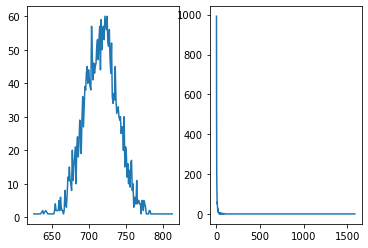

In [97]:
erdos_renyi_similarity(G1)

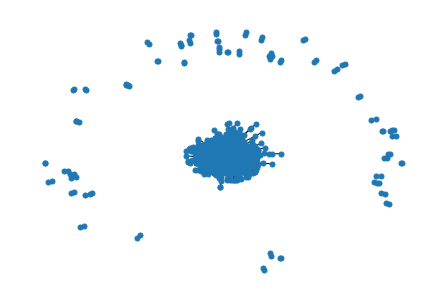

In [98]:
nx.draw(G1, node_size=25)